In [1]:
use_trained = True

In [2]:
import sys
sys.path.append('../../datasets/')
from prepare_sequences import prepare, germanBats
import matplotlib.pyplot as plt

classes = germanBats

In [25]:
num_bands = 257
patch_len = 44                               # = 250ms ~ 25ms
patch_skip = patch_len / 2                   # = 150ms ~ 15ms

resize = None

mode = 'slide'
options = {
    'seq_len': 60,                            # = 500ms with ~ 5 calls
    'seq_skip': 60,
}

X_test, Y_test = prepare("../../datasets/prepared.h5", classes, patch_len, patch_skip,
                                                         options, mode, resize, only_val=True)

100%|███████████████████████████████████████████| 18/18 [00:20<00:00,  1.12s/it]


In [26]:
print("Total sequences:", len(X_test))
print(X_test.shape, Y_test.shape)

Total sequences: 728
(728, 60, 44, 257) (728,)


In [5]:
import time
import datetime
import numpy as np
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [27]:
batch_size = 64
num_classes = len(list(classes))

test_data = TensorDataset(torch.Tensor(X_test), torch.from_numpy(Y_test))
test_loader = DataLoader(test_data, batch_size=batch_size)

In [7]:
from bat_2 import Net

max_len = 60
d_model = 64 

nhead = 2
dim_feedforward = 32
num_layers = 2
dropout = 0.3
classifier_dropout = 0.3

model = Net(
    max_len=max_len,
    patch_dim=resize[0]*resize[1] if resize is not None else patch_len * num_bands, # patch_len * num_bands, # 44 * 257 = 11,308
    d_model=d_model,
    num_classes=len(list(classes)),
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    dropout=dropout,
    classifier_dropout=classifier_dropout,
)
if use_trained:
    model.load_state_dict(torch.load('bat_2_convnet_mixed.pth'))
else:
    model.load_state_dict(torch.load('bat_2_convnet.pth'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
    
model.to(device)
print(device)

cuda:0


In [8]:
from sklearn.metrics import hamming_loss, f1_score

corrects = 0.0

pred = []
true = []

model.eval()

# iterate over test data
for inputs, labels in tqdm.tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    
    output = model(inputs) # Feed Network
    prediction = torch.argmax(output, 1)
    pred.extend(prediction.cpu().detach().numpy())
    true.extend(labels.cpu().detach().numpy())
    corrects += (prediction == labels).sum()
    
print("Test acc:", corrects / len(test_data))
print("F1-score", f1_score(np.asarray(pred), np.asarray(true), average='macro'))

100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  8.03it/s]

Test acc: tensor(0.9042, device='cuda:0')
F1-score 0.8621102086286759


In [9]:
import random

def one_hot(x, num_classes, on_value=1., off_value=0., device='cuda'):
    x = x.long().view(-1, 1)
    return torch.full((x.size()[0], num_classes), off_value, device=device).scatter_(1, x, on_value)

def rand_y(Y, exclude_class):
    while True:
        idx = random.randint(0, len(Y)-1)
        if torch.logical_and(Y[idx], exclude_class).sum() == 0:
            return idx

def mixup(X, Y, num_classes, min_seq=2, max_seq=2):
    Y1 = one_hot(Y, num_classes, device=X.device)
    X2 = X.clone()
    Y2 = Y1.clone()
    for i, y in enumerate(Y):
        rand_k = random.randint(min_seq, max_seq)
        for k in range(3-rand_k):
            idx = rand_y(Y1, Y2[i])
            X2[i] += X[idx].squeeze()
            Y2[i] += Y1[idx].squeeze()
    return X2, Y2

'''def getCorrects(output, target):
    n_targets = target.sum(dim=1).int().cpu().detach().numpy()
    best_2 = torch.zeros_like(output)
    for i, e in enumerate(torch.argsort(output, 1)):
        best_2[i, e[-n_targets[i]:]] = 1
    log_and = torch.logical_and(best_2, target)
    corr = 0.0
    for i, t in enumerate(target):
        corr += log_and[i].sum() / t.sum()
    return corr'''

def getCorrects(output, target):
    log_and = np.logical_and(output, target)
    corr = 0.0
    for i, t in enumerate(target):
        corr += log_and[i].sum() / max(t.sum(), output[i].sum())
    return corr

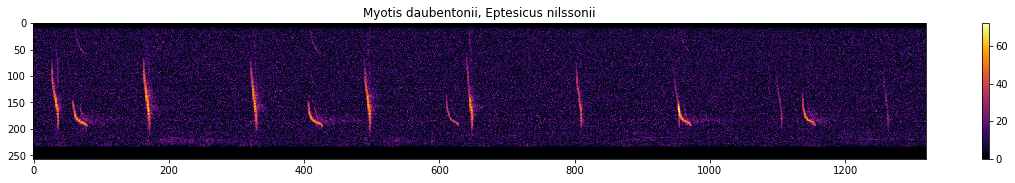

In [10]:
def stitch(a, r):
    return a[::r]
  
def plot_sequence(seq, y):
    plt.figure(figsize = (20, 2.5))
    stitched = stitch(seq, int(patch_len / patch_skip))
    spec = np.rot90(np.concatenate(stitched))
    plt.imshow(spec, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    label_list = []
    if(len(y.shape) > 0):
        for i in np.argwhere(y == 1)[:,0]:
            label_list.append(list(classes)[i])
        plt.title(", ".join(label_list))
    else:
        plt.title(list(classes)[y])

k = random.randint(0, batch_size-1)
X1, Y1 = next(iter(test_loader))
X1, Y1 = mixup(X1, Y1, num_classes=num_classes, min_seq=1, max_seq=3)
plot_sequence(X1[k].detach().numpy(), Y1[k].detach().numpy())

In [11]:
torch.cuda.empty_cache() 

In [28]:
repeats = 5

predictions = []
targets = []

for r in range(repeats):
    # iterate over test data
    for inputs, labels in tqdm.tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, num_classes=num_classes, min_seq=1, max_seq=3)
        
        output = model(inputs) # Feed Network
        predictions.extend(output.data.cpu().numpy())
        targets.extend(labels.data.cpu().numpy())

100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.37it/s]


In [32]:
from sklearn.metrics import hamming_loss, f1_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

predictions2 = []
targets2 = []
for p, t in zip(predictions, targets):
    if t[0] != 1 and t[1] != 1 and t[16] != 1:
        predictions2.append(p)
        targets2.append(t)

labels = sigmoid(np.asarray(predictions2)) > 0.33
print("Mixed test acc:", getCorrects(labels, np.asarray(targets2)) / (repeats * len(test_data)))
print("Mixed f1 micro:", f1_score(labels, np.asarray(targets2), average='micro'))
print("Mixed f1 macro:", f1_score(labels, np.asarray(targets2), average='macro'))

Mixed test acc: 0.5609160284160284
Mixed f1 micro: 0.7043244855353414
Mixed f1 macro: 0.5451889350612672
